In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import cv2

import functions as fn

In [2]:
dataDir='../data'
trainDir='train2017'
valDir='val2017'

trainAnn=f'{dataDir}/annotations/instances_{trainDir}.json'
valAnn=f'{dataDir}/annotations/instances_{valDir}.json'

cocoTrain=COCO(trainAnn)
cocoVal=COCO(valAnn)

catIdsTrain = cocoTrain.getCatIds(catNms=['person'])
imgIdsTrain = cocoTrain.getImgIds(catIds=catIdsTrain)
imgIdsTrain = cocoTrain.getImgIds(imgIds=imgIdsTrain)

catIdsVal = cocoVal.getCatIds(catNms=['person'])
imgIdsVal = cocoVal.getImgIds(catIds=catIdsVal)
imgIdsVal = cocoVal.getImgIds(imgIds=imgIdsVal)

loading annotations into memory...
Done (t=9.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


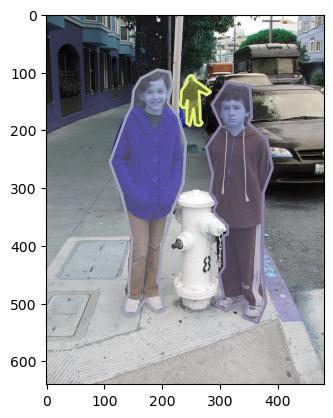

In [3]:
img = {'license': 3,
 'file_name': '000000102771.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000102771.jpg',
 'height': 640,
 'width': 480,
 'date_captured': '2013-11-16 21:36:01',
 'flickr_url': 'http://farm4.staticflickr.com/3141/3060074174_c540b56d2e_z.jpg',
 'id': 102771}

fpath = '{}/{}/{}'.format(dataDir, trainDir, img['file_name'])

test_img = cv2.imread(fpath, -1)

fn.remove_true_blacks(test_img)

plt.imshow(test_img)

anns_ids = cocoTrain.getAnnIds(imgIds=img['id'], catIds=catIdsTrain, iscrowd=None)
anns = cocoTrain.loadAnns(anns_ids)
cocoTrain.showAnns(anns)

In [4]:
ann = anns[0]

test_masked_img, test_masked_img_inv = fn.generate_masked_images(test_img, ann)

fn.display_image(test_masked_img, window_name='Masked')

In [5]:
#mask = test_img == 0

#mask

In [6]:
#test_img[mask] = 1

In [7]:
mask = test_img == 0

#mask

In [8]:
np.where(mask)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [9]:
def apply_rolling_shutter(masked_img, inv_masked_img, ann, interval=5, strategy='right'):
    masked_output = np.copy(masked_img)
    inv_masked_output = np.copy(inv_masked_img)

    ymin = int(np.round(ann['bbox'][1]))
    ymax = int(np.round(ann['bbox'][1] + ann['bbox'][3]))

    for row in np.arange(ymin - 1, ymax + 1):
        masked_output[row] = fn.shift_array(masked_output[row], int(row / interval), direction=strategy)
    
    return masked_output

test_post_rs = apply_rolling_shutter(test_masked_img, test_masked_img_inv, ann, interval=8, strategy='left')

In [10]:
#def recombine_masked_imgs(masked_img, inv_masked_img):
#    output = np.copy(inv_masked_img)
#    mask = masked_img > 0
#    output[mask] = masked_img[mask]
#    return output

fn.display_image(fn.recombine_masked_imgs(test_post_rs, test_masked_img_inv))

In [11]:
mask = np.array([[1, 2], [3, 4]])

print(mask)

new_mask = fn.shift_array(mask)

print(new_mask)

[[1 2]
 [3 4]]
[[3 4]
 [1 2]]


In [12]:
test_arr = np.copy(test_masked_img_inv)

len(np.where(test_arr == 0)[0])

101742

In [13]:
def fill_inv_masked(inv_masked_img, ann):
    output = np.copy(inv_masked_img)

    ymin = int(np.round(ann['bbox'][1]))
    ymax = int(np.round(ann['bbox'][1] + ann['bbox'][3]))

    for row in np.arange(ymin - 1, ymax + 1):
        blacks = np.sort(np.array(list(set(np.where(output[row] == np.array([0, 0, 0]))[0]))))
        mdpt = blacks[int(len(blacks) / 2)]
        left_len = mdpt - blacks[0]
        right_len = blacks[-1] - mdpt
        left_arr = np.flip(output[row][blacks[0] - left_len:blacks[0]], axis=0)
        right_arr = np.flip(output[row][blacks[-1] + 1:blacks[-1] + right_len + 2], axis=0)
        output[row][blacks[0]:mdpt] = left_arr
        output[row][mdpt:blacks[-1] + 1] = right_arr
    
    return output

filled_test_inv = fn.fill_inv_masked(test_masked_img_inv, ann)

#fn.display_image(filled_test_inv)

fn.display_image(fn.recombine_masked_imgs(test_post_rs, filled_test_inv))

In [14]:
ymin = int(np.round(ann['bbox'][1]))

foo = test_masked_img_inv[ymin + 20]

foo

array([[37, 34, 29],
       [34, 30, 36],
       [25, 28, 19],
       ...,
       [ 9, 10,  6],
       [14, 17,  8],
       [28, 33, 18]], dtype=uint8)

In [15]:
blacks = np.array(list(set(np.where(foo == np.array([0, 0, 0]))[0])))
blacks

array([159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216], dtype=int64)

In [16]:
mdpt = blacks[int(len(blacks) / 2)]
mdpt

188

In [39]:
left_len = mdpt - blacks[0]
left_len

29

In [40]:
right_len = blacks[-1] - mdpt
right_len

28

In [41]:
#foo[158]

In [42]:
left_arr = foo[blacks[0] - left_len:blacks[0]]
left_arr

array([[41, 33, 34],
       [88, 85, 87],
       [83, 91, 91],
       [75, 86, 84],
       [15, 20, 18],
       [22, 17, 14],
       [31, 35, 36],
       [21, 28, 23],
       [31, 40, 37],
       [24, 27, 31],
       [ 8,  8,  8],
       [38, 37, 33],
       [24, 26, 20],
       [18, 26, 15],
       [16, 17, 15],
       [ 4,  5,  3],
       [33, 33, 33],
       [37, 39, 39],
       [36, 40, 41],
       [18, 22, 23],
       [17, 22, 25],
       [23, 30, 33],
       [31, 36, 39],
       [32, 36, 41],
       [17, 23, 30],
       [33, 39, 44],
       [35, 43, 43],
       [24, 30, 29],
       [37, 41, 42]], dtype=uint8)

In [43]:
left_arr = np.flip(left_arr, axis=0)
left_arr

array([[37, 41, 42],
       [24, 30, 29],
       [35, 43, 43],
       [33, 39, 44],
       [17, 23, 30],
       [32, 36, 41],
       [31, 36, 39],
       [23, 30, 33],
       [17, 22, 25],
       [18, 22, 23],
       [36, 40, 41],
       [37, 39, 39],
       [33, 33, 33],
       [ 4,  5,  3],
       [16, 17, 15],
       [18, 26, 15],
       [24, 26, 20],
       [38, 37, 33],
       [ 8,  8,  8],
       [24, 27, 31],
       [31, 40, 37],
       [21, 28, 23],
       [31, 35, 36],
       [22, 17, 14],
       [15, 20, 18],
       [75, 86, 84],
       [83, 91, 91],
       [88, 85, 87],
       [41, 33, 34]], dtype=uint8)

In [44]:
foo[blacks[0]:mdpt] = left_arr

In [45]:
right_arr = foo[blacks[-1]:blacks[-1] + right_len]
right_arr = np.flip(right_arr, axis=0)
right_arr

array([[203, 186, 196],
       [205, 202, 211],
       [232, 237, 233],
       [183, 201, 211],
       [113, 119, 117],
       [131, 134, 143],
       [ 83,  82,  90],
       [ 76,  76,  68],
       [102, 100,  87],
       [ 71,  68,  63],
       [ 73,  72,  70],
       [ 27,  26,  21],
       [109, 110, 104],
       [213, 213, 213],
       [186, 187, 192],
       [189, 189, 197],
       [178, 181, 186],
       [169, 173, 174],
       [163, 167, 170],
       [163, 168, 172],
       [157, 166, 171],
       [178, 176, 179],
       [175, 186, 182],
       [191, 195, 198],
       [210, 219, 228],
       [ 79,  96, 103],
       [ 14,   8,  12],
       [  0,   0,   0]], dtype=uint8)

In [46]:
foo[mdpt:blacks[-1]] = right_arr